# Developer Gamma-gamma model PyMC implementation

**Reference**:Fader, P. S., & Hardie, B. G. (2013). The Gamma-Gamma model of monetary value. February, 2, 1-9.

http://www.brucehardie.com/notes/025/gamma_gamma.pdf

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

In [3]:
from pymc_marketing import clv

## Simulate data

In [4]:
rng = np.random.default_rng(42)

# Hyperparameters
p_true = 6.
q_true = 4.
v_true = 15.

# Number of subjects
N = 500  
# Subject level parameters
nu_true = pm.draw(pm.Gamma.dist(q_true, v_true, size=N), random_seed=rng)

# Number of observations per subject
x = rng.poisson(lam=2, size=N) + 1  
idx = np.repeat(np.arange(0, N), x)
# Observations
z = pm.draw(pm.Gamma.dist(p_true, nu_true[idx]), random_seed=rng)

In [5]:
print(sum(x))
assert len(nu_true[idx]) == sum(x)

1503


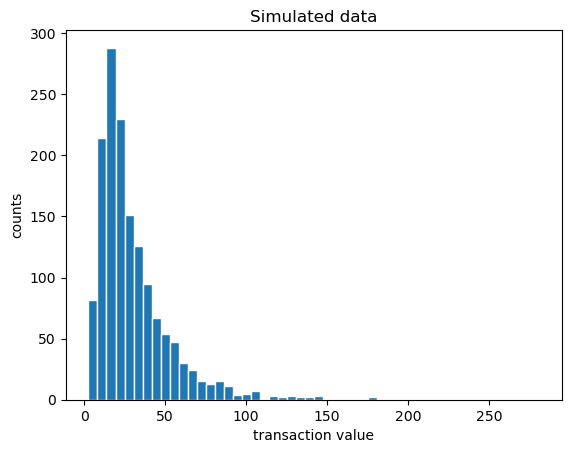

In [6]:
plt.hist(z, bins=50, ec="w")
plt.xlabel("transaction value")
plt.ylabel("counts")
plt.title("Simulated data");

In [13]:
df = pd.DataFrame(data={"individual_transaction_value": z, "customer_id": idx})
z_mean = df.groupby("customer_id").mean()["individual_transaction_value"].values
z_mean[:10]

array([ 17.5597973 ,  41.05272046,  15.90609488,  83.95307047,
        20.36896009,  23.8572992 ,  46.09000842,  47.49876237,
       131.16095313,  16.42659393])

## PyMC implementation

We can use the pre-built PyMMMC implementation of the Gamma-Gamma model, which also provides nice ploting and prediction methods

### Using individual transactions 𝑧

In [14]:
model = clv.GammaGammaModelIndividual(data = df)

In [20]:
model

Gamma-Gamma Model (Individual Transactions)
    p ~ HalfFlat()
    q ~ HalfFlat()
    v ~ HalfFlat()
   nu ~ Gamma(q, f(v))
spend ~ Gamma(p, f(nu))

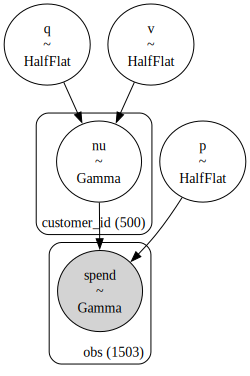

In [21]:
model.build_model()
model.graphviz()

In [9]:
model.fit(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

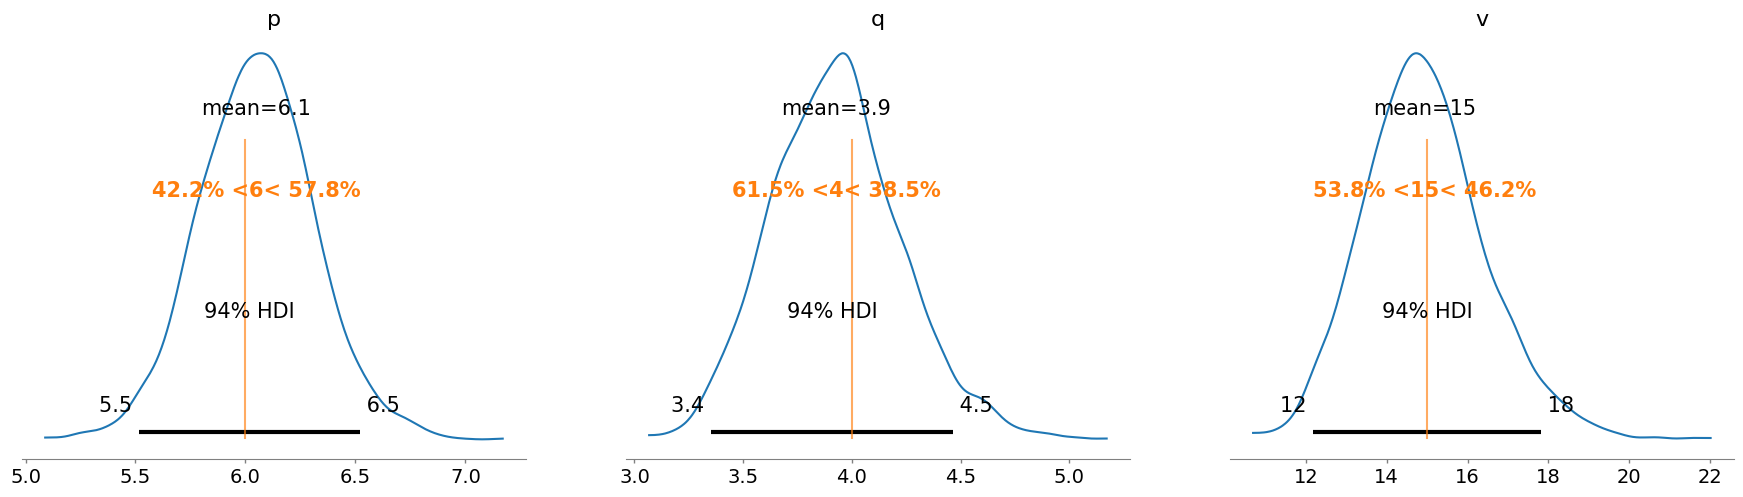

In [10]:
az.plot_posterior(model.fit_result, var_names=["p", "q", "v"], ref_val=[p_true, q_true, v_true]);

In [11]:
expected_spend = model.expected_customer_spend(
    customer_id=idx,
    individual_transaction_value=z,
).stack(sample=("draw", "chain"))

Sampling: [nu]


In [12]:
# Choose 10 lowest, median and 10 highest spending clients
selected_idxs = np.argsort(nu_true)[::-1][[10, 250, -10]]
selected_idxs

array([267, 407, 359])

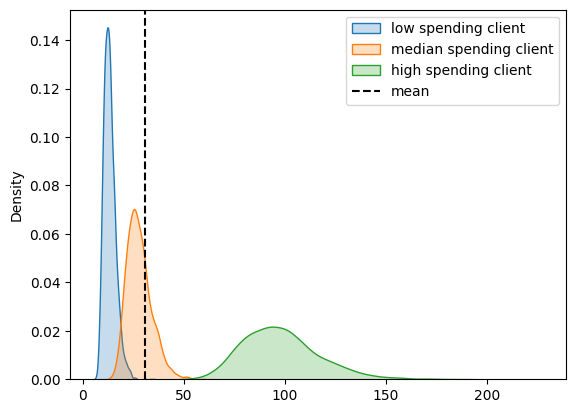

In [13]:
sns.kdeplot(expected_spend.sel(customer_id=selected_idxs[0]), fill=True, label="low spending client")
sns.kdeplot(expected_spend.sel(customer_id=selected_idxs[1]), fill=True, label="median spending client")
sns.kdeplot(expected_spend.sel(customer_id=selected_idxs[2]), fill=True, label="high spending client")
plt.axvline(expected_spend.mean(), color="k", ls="--", label="mean")
plt.legend();

In [14]:
new_spend = model.expected_new_customer_spend().stack(sample=("chain", "draw"))

Sampling: [nu]


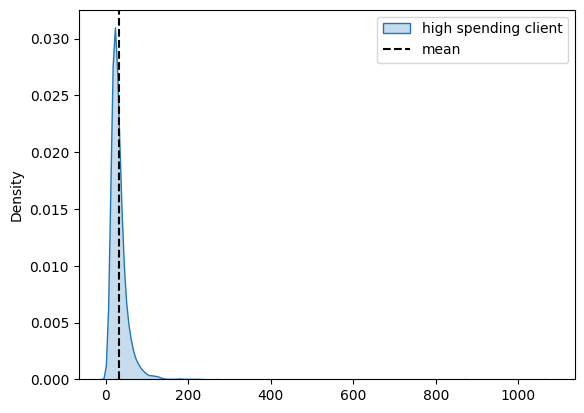

In [15]:
sns.kdeplot(new_spend.isel(new_customer_id=0), fill=True, label="high spending client")
plt.axvline(new_spend.mean(), color="k", ls="--", label="mean")
plt.legend();

### Using average transactions per user $\overline{z}$

In [16]:
model = clv.GammaGammaModel(
    customer_id=idx,
    mean_transaction_value=z_mean,
    frequency=x,
)
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [17]:
model.fit(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Inference data with groups:
	> posterior
	> sample_stats

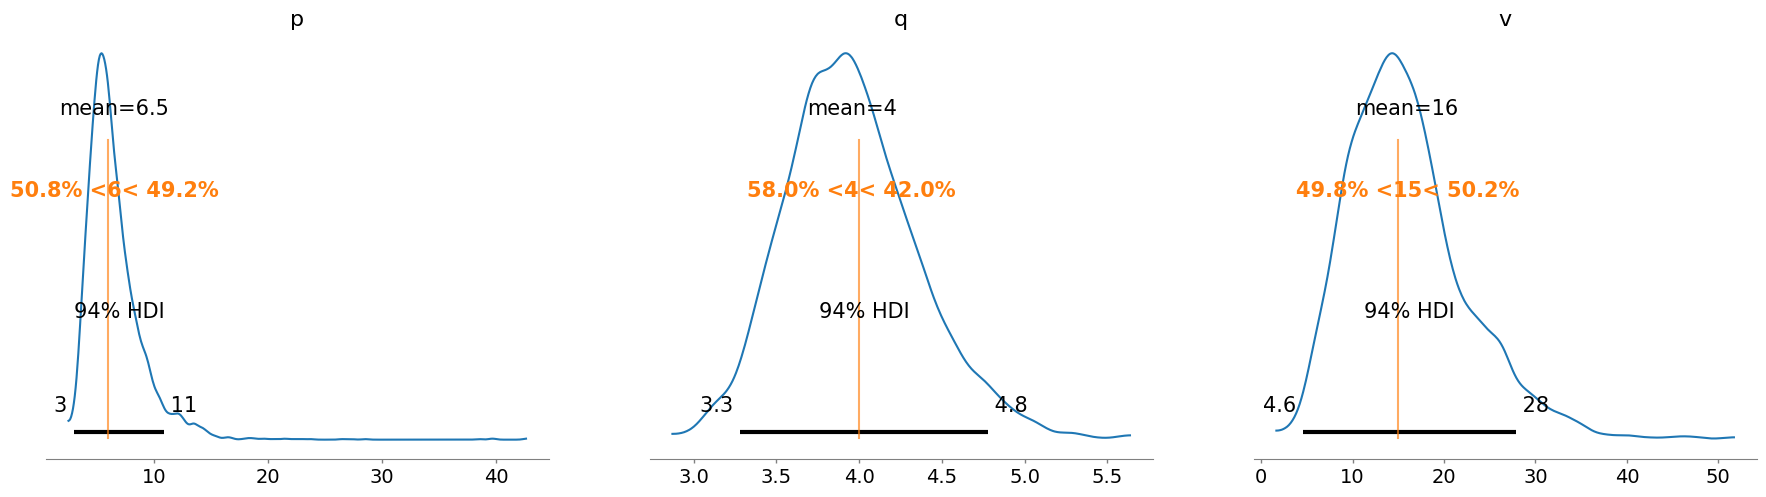

In [18]:
az.plot_posterior(model.fit_result, var_names=["p", "q", "v"], ref_val=[p_true, q_true, v_true]);

In [19]:
expected_spend = model.expected_customer_spend(
    customer_id=idx,
    mean_transaction_value=z_mean,
    frequency=x,
).stack(sample=("draw", "chain"))

Sampling: [nu]


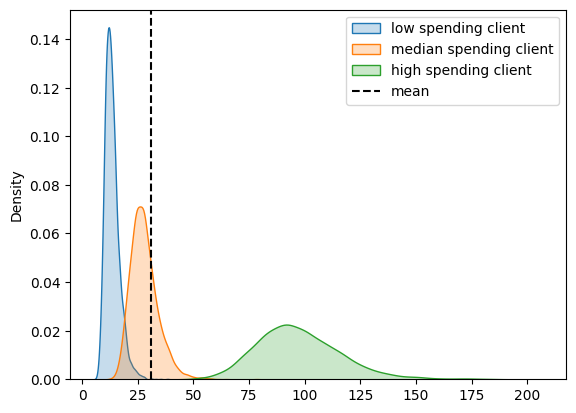

In [20]:
sns.kdeplot(expected_spend.sel(customer_id=selected_idxs[0]), fill=True, label="low spending client")
sns.kdeplot(expected_spend.sel(customer_id=selected_idxs[1]), fill=True, label="median spending client")
sns.kdeplot(expected_spend.sel(customer_id=selected_idxs[2]), fill=True, label="high spending client")
plt.axvline(expected_spend.mean(), color="k", ls="--", label="mean")
plt.legend();

In [21]:
new_spend = model.expected_new_customer_spend().stack(sample=("chain", "draw"))

Sampling: [nu]


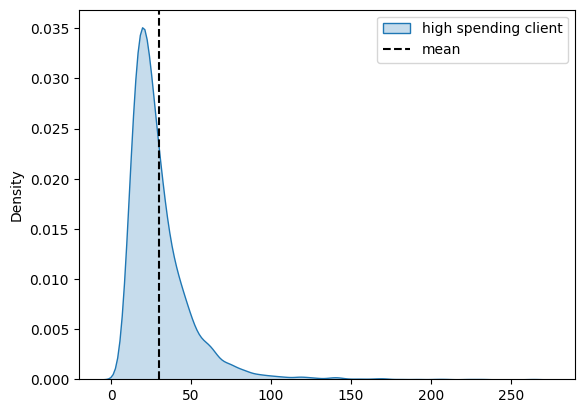

In [22]:
sns.kdeplot(new_spend.isel(new_customer_id=0), fill=True, label="high spending client")
plt.axvline(new_spend.mean(), color="k", ls="--", label="mean")
plt.legend();

## Manual PyMC implementations

We show how the Gamma-Gamma model can be implemented by hand using PyMC. This clarifies how the model can be modified or extended to include more prior information or additional structure.

### Gamma-Gamma model conditioned on individual transactions $z$

In [23]:
with pm.Model() as m1:
    p = pm.HalfFlat("p")
    q = pm.HalfFlat("q")
    v = pm.HalfFlat("v")
    
    nu = pm.Gamma("nu", q, v, size=N)
    pm.Gamma("z", p, nu[idx], observed=z)

    pm.Deterministic("mean_spend", p / nu)
    
    trace1 = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [24]:
az.summary(trace1, var_names=["p", "q", "v"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,6.055,0.260,5.578,6.564,0.020,0.014,178.0,382.0,1.02
q,3.914,0.295,3.358,4.453,0.007,0.005,1877.0,1959.0,1.00
v,14.879,1.486,12.194,17.717,0.071,0.050,438.0,1131.0,1.01


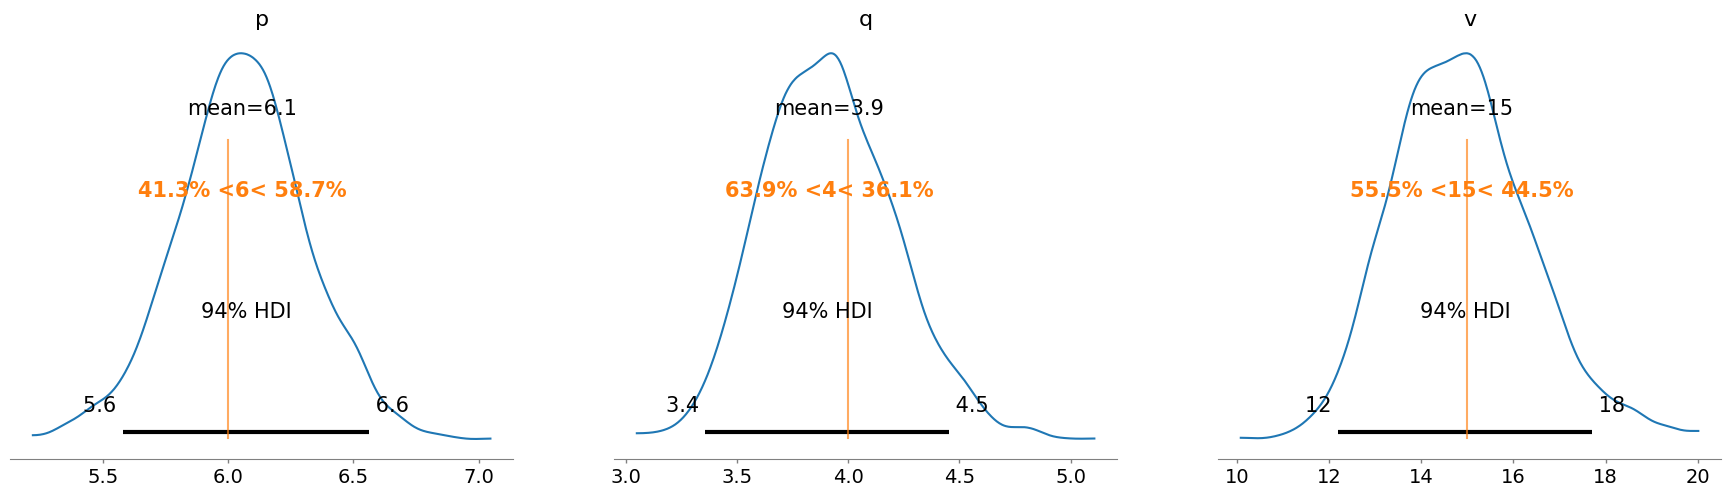

In [25]:
az.plot_posterior(trace1, var_names=["p", "q", "v"], ref_val=[p_true, q_true, v_true]);

### Gamma-gamma model conditioned on average transactions per user $\overline{z}$

This fails to sample because the model contains "nearly" two independent parameters per observation. For more details check this [Discourse topic](https://discourse.pymc.io/t/gamma-model-sampling-much-worse-when-observation-summaries-are-used-instead-of-individual-observations/10444)

In [26]:
with pm.Model() as m2:
    p = pm.HalfFlat("p")
    q = pm.HalfFlat("q")
    v = pm.HalfFlat("v")

    nu = pm.Gamma("nu", q, v, size=N)
    # We use the convolution properties of the gamma distribution to model
    # the mean of multiple transaction using the parameters of individual
    # transactions
    pm.Gamma("z_mean", p*x, nu*x, observed=z_mean)
    
    trace2 = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [27]:
az.summary(trace2, var_names=["p", "q", "v"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,14.454,11.819,4.299,40.762,5.738,4.375,5.0,11.0,2.17
q,3.629,0.376,2.939,4.294,0.129,0.094,8.0,41.0,1.41
v,9.154,5.062,1.340,16.853,2.264,1.705,5.0,11.0,2.09


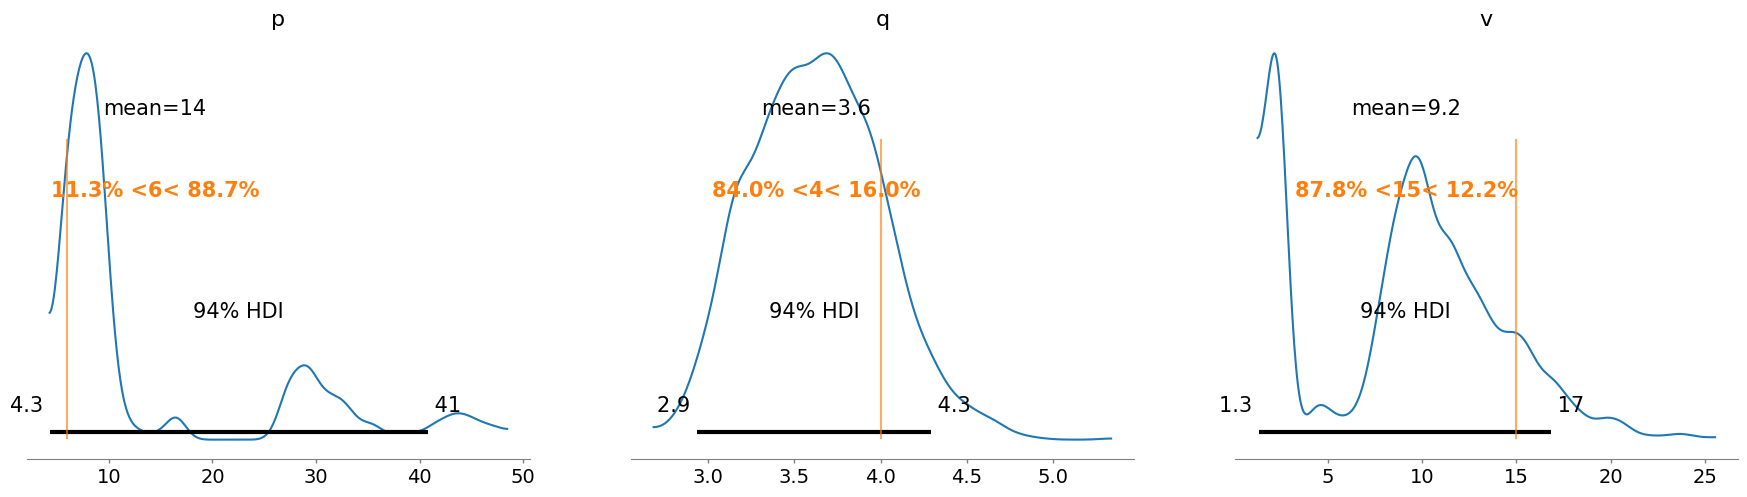

In [28]:
az.plot_posterior(trace2, var_names=["p", "q", "v"], ref_val=[p_true, q_true, v_true]);

### Gamma-Gamma model conditioned on average transaction per user with $\nu$ marginalized

In [29]:
with pm.Model() as m3:
    p = pm.HalfFlat("p")
    q = pm.HalfFlat("q")
    v = pm.HalfFlat("v")

    # Likelihood of z_mean, marginalizing over nu
    likelihood = pm.Potential(
        "likelihood", 
        (
            pt.gammaln(p * x + q)
            - pt.gammaln(p * x)
            - pt.gammaln(q)
            + q * pt.log(v)
            + (p * x - 1) * pt.log(z_mean)
            + (p * x) * pt.log(x)
            - (p * x + q) * pt.log(x * z_mean + v)
        ),
    )

    # Closed form solution posterior individual nu
    nu = pm.Deterministic("nu", pm.Gamma.dist(p * x + q, v + x * z_mean))
    pm.Deterministic("mean_spend", p / nu)
    
    trace3 = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [30]:
az.summary(trace3, var_names=["p", "q", "v"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,6.845,2.937,3.153,12.110,0.110,0.080,865.0,812.0,1.0
q,3.915,0.390,3.194,4.654,0.012,0.009,974.0,1118.0,1.0
v,15.375,6.510,4.445,26.879,0.221,0.156,816.0,738.0,1.0


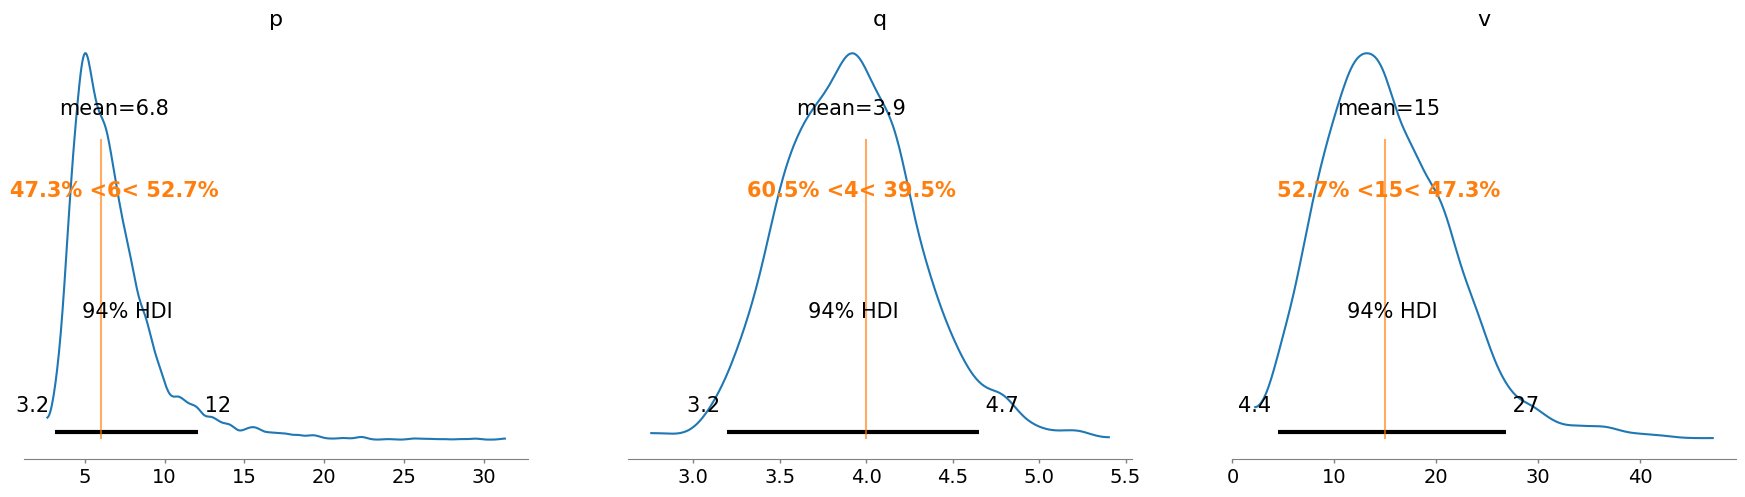

In [31]:
az.plot_posterior(trace3, var_names=["p", "q", "v"], ref_val=[p_true, q_true, v_true]);